In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein
import numpy as np
import math
import statistics
from sklearn.metrics import confusion_matrix
import os
from tqdm import tqdm

Siamese Network using TypeNet

Contrastive Loss is used only during training, not during evaluation or prediction. Its purpose is to train the Siamese network to learn embeddings in a way that embeddings of genuine pairs are close together (similarity) and embeddings of impostor pairs are far apart (dissimilarity).

Training:
During training, the Siamese network is fed pairs of embeddings (emb1 and emb2) along with their corresponding labels (target). The Contrastive Loss is computed using these pairs and labels, and it measures how similar the embeddings are for genuine pairs and how dissimilar they are for impostor pairs. The model's parameters are updated using gradient descent to minimize this loss. The similarity scores are not directly produced during training; they are used internally by the Contrastive Loss function to optimize the model's embeddings.

Evaluation:
After training, the model is evaluated on a separate test dataset. During evaluation, you compute the embeddings for genuine and impostor pairs using the trained Siamese network. Then, you calculate the Euclidean distance between these embeddings, but you do not use the Contrastive Loss during this process. Then calculate the similarity score of these euclidian distance and create a new dataset where all the scores and labels are stored.

In [2]:
dataset1 = pd.read_csv("dataset1.csv")
dataset1

,USER_ID,Thil_count,Thil_mean,Thil_median,Thil_pstdev,Thil_max,Thil_min,Thpl_count,Thpl_mean,Thpl_median,...,girl_median,girl_pstdev,girl_max,girl_min,gihl_count,gihl_mean,gihl_median,gihl_pstdev,gihl_max,gihl_min
0,21833_1,1.0,27889.000000,27889.0,0.000000,27889.0,27889.0,1.0,112225.000000,112225.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21833_2,1.0,15129.000000,15129.0,0.000000,15129.0,15129.0,1.0,555025.000000,555025.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,233209_2,3.0,3744.666667,3969.0,2135.730372,6241.0,1024.0,3.0,132320.333333,20736.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39734_2,2.0,2592.500000,2592.5,1503.500000,4096.0,1089.0,2.0,23552.500000,23552.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,285679_2,2.0,9176.500000,9176.5,1432.500000,10609.0,7744.0,2.0,43840.000000,43840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,160159_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27353,349891_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27354,144723_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27355,163905_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
dataset2 = pd.read_csv("dataset2.csv")
dataset2

,User ID #1,User ID #2,Label
0,21833_1,21833_2,0
1,233209_2,233209_1,0
2,39734_2,39734_1,0
3,285679_2,285679_1,0
4,206052_1,206052_2,0
...,...,...,...
25701,183297_1,154453_2,1
25702,44951_2,342622_1,1
25703,388515_1,62296_2,1
25704,11462_1,82765_2,1


In [4]:
dataset1 = dataset1.applymap(lambda x: np.log1p(x) if isinstance(x, (int, float)) else x)
mean_values = dataset1.mean()
dataset1.fillna(mean_values, inplace = True)

In [5]:
import transformers
import mlflow

mlflow.set_tracking_uri("http://localhost:5002")
mlflow.set_experiment("SiameseKeystrokeExperiment2")

mlflow.start_run()

<ActiveRun: >

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from scipy.optimize import brentq
import torch.nn.functional as F

In [7]:
import torch
from sklearn.preprocessing import MinMaxScaler

class SiameseKeystrokeDataset(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.min_max_scaler = MinMaxScaler()
        self.min_max_scaler.fit(dataset1.values[:, 1:-1])

    def __len__(self):
        return len(self.dataset2)

    def __getitem__(self, index):
        user1, user2, label = self.dataset2.loc[index]
        
        features1 = self.dataset1[self.dataset1['USER_ID'] == user1]
        features2 = self.dataset1[self.dataset1['USER_ID'] == user2]

        inputs = (features1.values[:, 1:-1], features2.values[:, 1:-1])
        label = torch.tensor(label)

        inputs_transformed = []
        for i, feature_set in enumerate(inputs):
            transformed_feature_set = self.min_max_scaler.transform(feature_set)
            inputs_transformed.append(transformed_feature_set)

        inputs_tensor = [torch.tensor(item).float() for item in inputs_transformed]

        return inputs_tensor, label

In [8]:
"""
class SiameseKeystrokeDataset(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        user1, user2, label = self.dataset2.loc[index]
        
        features1 = self.dataset1[self.dataset1['USER_ID'] == user1]
        features2 = self.dataset1[self.dataset1['USER_ID'] == user2]

        inputs = (features1.values[:, 1:-1], features2.values[:, 1:-1])
        label = torch.tensor(label)

        return inputs, label

    def __len__(self):
        return len(self.dataset2)
"""

"\nclass SiameseKeystrokeDataset(torch.utils.data.Dataset):\n    def __init__(self, dataset1, dataset2):\n        self.dataset1 = dataset1\n        self.dataset2 = dataset2\n\n    def __getitem__(self, index):\n        user1, user2, label = self.dataset2.loc[index]\n        \n        features1 = self.dataset1[self.dataset1['USER_ID'] == user1]\n        features2 = self.dataset1[self.dataset1['USER_ID'] == user2]\n\n        inputs = (features1.values[:, 1:-1], features2.values[:, 1:-1])\n        label = torch.tensor(label)\n\n        return inputs, label\n\n    def __len__(self):\n        return len(self.dataset2)\n"

In [9]:
class TypeNet(nn.Module):
    def __init__(self):
        super(TypeNet, self).__init__()
        self.bn1 = nn.BatchNorm1d(4439)
        self.lstm1 = nn.LSTM(input_size=4439, hidden_size=128, num_layers=1, dropout=0.2, bidirectional=False)
        self.dropout1 = nn.Dropout(p=0.5)
        self.bn2 = nn.BatchNorm1d(128)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, dropout=0.2, bidirectional=False)
        self.embedding = nn.Linear(128, 128)

    def forward(self, x, training=True):
        batch_size, seq_length, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.bn1(x)

        x = x.view(batch_size, seq_length, input_size)
        x, _ = self.lstm1(x)

        x = self.dropout1(x)

        batch_size, seq_length, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.bn2(x)

        x = x.view(batch_size, seq_length, input_size) 
        x, _ = self.lstm2(x)

        x = x[:, -1, :]
        x = self.embedding(x) 
        return x

In [10]:
def preprocess(batch):
    inputs, labels = zip(*batch)

    if isinstance(labels, pd.DataFrame):
        labels = labels.values

    inputs1 = []
    inputs2 = []
    object_columns = []
    for item in inputs:
        if isinstance(item[0], np.ndarray) and item[0].dtype == np.object_:
            object_columns.extend(range(item[0].shape[1]))  
            item1 = torch.tensor(item[0].astype(int)).float().clone().detach()
        else:
            item1 = item[0].clone().detach().float()

        if isinstance(item[1], np.ndarray) and item[1].dtype == np.object_:
            object_columns.extend(range(item[1].shape[1])) 
            item2 = torch.tensor(item[1].astype(int)).float().clone().detach()
        else:
            item2 = item[1].clone().detach().float()

        inputs1.append(item1)
        inputs2.append(item2)

    labels = torch.tensor(labels, dtype=torch.float32)

    non_empty_indices = [i for i, seq in enumerate(inputs1) if seq.size(0) > 0]
    if len(non_empty_indices) == 0:
        print("True")
        return None

    return (torch.stack(inputs1), torch.stack(inputs2)), labels

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self, rnn_model1, rnn_model2):
        super(SiameseNetwork, self).__init__()
        self.rnn_model1 = rnn_model1
        self.rnn_model2 = rnn_model2
        
    def forward(self, inputs):
        inputs1, inputs2 = inputs
        emb1 = self.rnn_model1(inputs1)
        emb2 = self.rnn_model2(inputs2)
        
        return emb1, emb2

In [12]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1 - target) * torch.pow(euclidean_distance, 2) +
                                      (target) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

siamese_dataset = SiameseKeystrokeDataset(dataset1, dataset2)
train_size = int(0.8 * len(siamese_dataset))
validate_size = int(0.1 * len(siamese_dataset))
test_size = len(siamese_dataset) - train_size - validate_size
train_dataset, validate_dataset, test_dataset = torch.utils.data.random_split(siamese_dataset, [train_size, validate_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=preprocess)
validate_dataloader = DataLoader(validate_dataset, batch_size=16, shuffle=False, collate_fn=preprocess)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=preprocess)

rnn_model1 = TypeNet().to(device)
rnn_model2 = TypeNet().to(device)

siamese_model = SiameseNetwork(rnn_model1, rnn_model2).to(device)

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
mlflow.log_params({
    "learning_rate": 0.0001,
    "epochs": 10,
    "batch_size": 16,
    "hidden_size": 128,
    "num_layers": 1,
    "dropout": 0.5,
    "margin": 1
})

In [15]:
from tqdm import tqdm

criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_model.parameters(), lr=0.0001)

siamese_model.train()
num_iterations = 0

for epoch in range(5):
    train_loss = 0.0  # Initialize loss for each epoch
    train_dataloader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{5}")

    for batch_idx, ((inputs1, inputs2), labels) in enumerate(train_dataloader_tqdm): 
        num_iterations += 1
        inputs1, inputs2 = inputs1.to(device), inputs2.to(device) 
        labels = labels.to(device)

        optimizer.zero_grad()
        emb1, emb2 = siamese_model((inputs1, inputs2)) 
        loss = criterion(emb1, emb2, labels)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        if batch_idx % 10 == 0:
            train_dataloader_tqdm.set_postfix({"Loss": loss.item()})
            mlflow.log_metric("train_loss", loss.item(), step=num_iterations)
        
        #del inputs1, inputs2, labels, emb1, emb2, loss
        #torch.cuda.empty_cache()

    mlflow.log_metric("train_loss_epoch", train_loss / len(train_dataloader), step=epoch)

    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{5}], Average Loss: {train_loss / len(train_dataloader):.4f}")

print("Number of Iterations in Training Loop:", num_iterations)


Epoch 2/5: 100%|██████████| 1286/1286 [01:29<00:00, 14.43it/s, Loss=0.256]


Epoch [2/5], Average Loss: 0.2528


Epoch 4/5: 100%|██████████| 1286/1286 [01:31<00:00, 14.12it/s, Loss=0.251]


Epoch [4/5], Average Loss: 0.2519


Epoch 5/5: 100%|██████████| 1286/1286 [01:30<00:00, 14.29it/s, Loss=0.243]

Number of Iterations in Training Loop: 6430


In [16]:
mlflow.pytorch.log_model(siamese_model, "siamese_model")

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

siamese_model.eval()
validation_scores = []
validation_labels = []
validation_fv = []

with torch.no_grad():
    for ((inputs1, inputs2), labels) in validate_dataloader:
        inputs1, inputs2 = inputs1.to(device), inputs2.to(device)  
        labels = labels.to(device)
        emb1, emb2 = siamese_model((inputs1, inputs2))
        #fv = torch.pow(emb1 - emb2, 2)
        #validation_fv.extend(fv.tolist())

        cos_sim = cosine_similarity(emb1.cpu().numpy(), emb2.cpu().numpy())
        similarity_score = torch.tensor(cos_sim)

        validation_scores.extend(similarity_score.cpu().numpy())
        validation_labels.extend(labels.cpu().numpy())

#validation_fv = torch.tensor(validation_fv).to(device)
print(len(validation_scores))
print(len(validation_labels))
val_res_df = pd.DataFrame({'score': validation_scores, 'label': validation_labels})
mean_scores = val_res_df['score'].apply(lambda x: sum(x) / len(x))
val_res_df['score'] = mean_scores

val_res_df

2570
2570


,score,label
0,0.658140,1.0
1,0.673055,1.0
2,0.635190,0.0
3,0.610609,1.0
4,0.634362,1.0
...,...,...
2565,0.635373,1.0
2566,0.641209,0.0
2567,0.646130,0.0
2568,0.674820,1.0


In [18]:
threshold = 0.5

val_res_df['predicted'] = (val_res_df['score'] >= threshold).astype(int)

accuracy = (val_res_df['predicted'] == val_res_df['label']).mean()

true_positive = ((val_res_df['predicted'] == 1) & (val_res_df['label'] == 1)).sum()
positive = (val_res_df['label'] == 1).sum()
tpr = true_positive / positive

false_positive = ((val_res_df['predicted'] == 1) & (val_res_df['label'] == 0)).sum()
negative = (val_res_df['label'] == 0).sum()
fpr = false_positive / negative

eer = (fpr + 1 - tpr) / 2

conf_matrix = confusion_matrix(val_res_df['label'], val_res_df['predicted'])

print("Accuracy:", accuracy)
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("Equal Error Rate (EER):", eer)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 1.0
Equal Error Rate (EER): 0.5
Confusion Matrix:
[[   0 1285]
 [   0 1285]]


/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


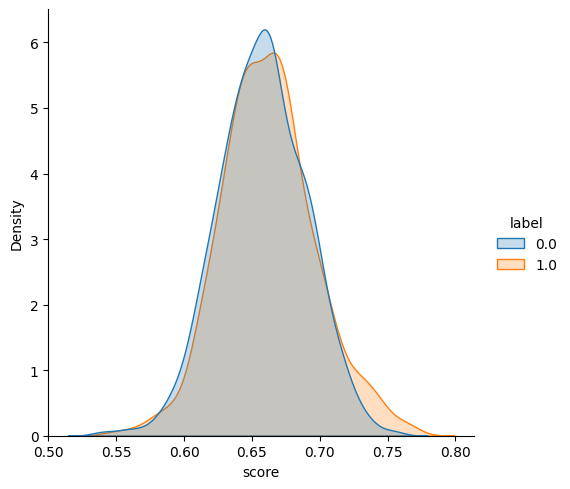

In [19]:
import seaborn as sns

fig = sns.displot(val_res_df, x="score", hue="label", kind="kde", fill=True)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

siamese_model.eval()
test_scores = []
test_labels = []
test_fv = []

with torch.no_grad():
    for ((inputs1, inputs2), labels) in test_dataloader:
        inputs1, inputs2 = inputs1.to(device), inputs2.to(device)  
        labels = labels.to(device)
        emb1, emb2 = siamese_model((inputs1, inputs2))

        cos_sim = cosine_similarity(emb1.cpu().numpy(), emb2.cpu().numpy())
        similarity_score = torch.tensor(cos_sim)

        test_scores.extend(similarity_score.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print(len(test_scores))
print(len(test_labels))
test_res_df = pd.DataFrame({'score': test_scores, 'label': test_labels})
mean_scores = test_res_df['score'].apply(lambda x: sum(x) / len(x))
test_res_df['score'] = mean_scores

test_res_df

2572
2572


,score,label
0,0.704139,0.0
1,0.677065,0.0
2,0.636457,0.0
3,0.681222,0.0
4,0.660202,1.0
...,...,...
2567,0.675726,1.0
2568,0.667082,0.0
2569,0.669531,1.0
2570,0.652902,1.0


In [21]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

test_res_df['predicted'] = (test_res_df['score'] >= threshold).astype(int)

accuracy = (test_res_df['predicted'] == test_res_df['label']).mean()

true_positive = ((test_res_df['predicted'] == 1) & (test_res_df['label'] == 1)).sum()
positive = (test_res_df['label'] == 1).sum()
tpr = true_positive / positive

false_positive = ((test_res_df['predicted'] == 1) & (test_res_df['label'] == 0)).sum()
negative = (test_res_df['label'] == 0).sum()
fpr = false_positive / negative

eer = (fpr + 1 - tpr) / 2

conf_matrix = confusion_matrix(test_res_df['label'], test_res_df['predicted'])

print("Accuracy:", accuracy)
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("Equal Error Rate (EER):", eer)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5031104199066874
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 1.0
Equal Error Rate (EER): 0.5
Confusion Matrix:
[[   0 1278]
 [   0 1294]]


/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


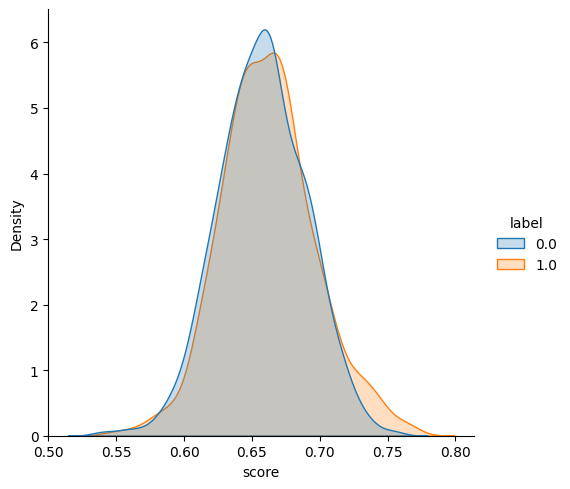

In [22]:
import seaborn as sns

fig = sns.displot(val_res_df, x="score", hue="label", kind="kde", fill=True)

In [23]:
mlflow.end_run()

Triplet Siamese Network in TypeNet using Triplet Loss

In [26]:
dataset3 = pd.read_csv("dataset3.csv")
dataset3

,User ID #1,User ID #2,User ID #3,Label
0,21833_1,21833_2,55271_1,1
1,233209_2,233209_1,82997_1,1
2,39734_2,39734_1,292111_1,1
3,285679_2,285679_1,120511_1,1
4,206052_1,206052_2,153152_1,1
...,...,...,...,...
25698,241162_2,241162_1,183780_1,1
25699,377941_2,377941_1,140578_1,1
25700,490934_2,490934_1,508721_1,1
25701,88629_2,88629_1,194187_1,1


In [27]:
class TripleSiameseKeystrokeDataset(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset3):
        self.dataset1 = dataset1
        self.dataset3 = dataset3

    def __getitem__(self, index):
        user_info = self.dataset3.loc[index]

        user1, user2, user3, label = user_info
        
        features1 = self.dataset1[self.dataset1['USER_ID'] == user1]
        features2 = self.dataset1[self.dataset1['USER_ID'] == user2]
        features3 = self.dataset1[self.dataset1['USER_ID'] == user3]

        inputs = (features1.values[:, 1:-1], features2.values[:, 1:-1], features3.values[:, 1:-1])
        #label = torch.tensor(label)

        return inputs

    def __len__(self):
        return len(self.dataset3)

In [29]:
def preprocess2(batch):
    inputs = zip(*batch)

    inputs1 = []
    inputs2 = []
    inputs3 = [] 
    object_columns = []
    for item in inputs:
        if isinstance(item[0], np.ndarray) and item[0].dtype == np.object_:
            object_columns.extend(range(item[0].shape[1]))
            item1 = torch.tensor(item[0].astype(int)).float()
        else:
            item1 = torch.tensor(item[0]).float()

        if isinstance(item[1], np.ndarray) and item[1].dtype == np.object_:
            object_columns.extend(range(item[1].shape[1]))
            item2 = torch.tensor(item[1].astype(int)).float()
        else:
            item2 = torch.tensor(item[1]).float()

        if isinstance(item[2], np.ndarray) and item[2].dtype == np.object_:
            object_columns.extend(range(item[2].shape[1]))
            item3 = torch.tensor(item[2].astype(int)).float()
        else:
            item3 = torch.tensor(item[2]).float()

        inputs1.append(item1)
        inputs2.append(item2)
        inputs3.append(item3)

    #labels = torch.tensor(labels, dtype=torch.float32)

    return (torch.stack(inputs1), torch.stack(inputs2), torch.stack(inputs3))


import torch.nn.functional as F

class TripleSiameseNetwork(nn.Module):
    def __init__(self, rnn_model1, rnn_model2, rnn_model3):
        super(TripleSiameseNetwork, self).__init__()
        self.rnn_model1 = rnn_model1
        self.rnn_model2 = rnn_model2
        self.rnn_model3 = rnn_model3

    def forward(self, inputs):
        inputs1, inputs2, inputs3 = inputs
        emb1 = self.rnn_model1(inputs1)
        emb2 = self.rnn_model2(inputs2)
        emb3 = self.rnn_model3(inputs3)
        return emb1, emb2, emb3

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True)
        loss_triplet = torch.mean(torch.clamp(distance_positive - distance_negative + self.margin, min=0.0))
        return loss_triplet
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

triplesiamese_dataset = TripleSiameseKeystrokeDataset(dataset1, dataset3)
train_size = int(0.8 * len(triplesiamese_dataset))
validate_size = int(0.1 * len(triplesiamese_dataset))
test_size = len(triplesiamese_dataset) - train_size - validate_size
train_dataset, validate_dataset, test_dataset = torch.utils.data.random_split(triplesiamese_dataset, [train_size, validate_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=preprocess2)
validate_dataloader = DataLoader(validate_dataset, batch_size=32, shuffle=False, collate_fn=preprocess2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=preprocess2)

rnn_model1 = TypeNet().to(device)
rnn_model2 = TypeNet().to(device)
rnn_model3 = TypeNet().to(device)

triplesiamese_model = TripleSiameseNetwork(rnn_model1, rnn_model2, rnn_model3).to(device)

#Training
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(triplesiamese_model.parameters(), lr=0.001)

triplesiamese_model.train()
train_loss = 0.0
num_iterations = 0

for epoch in range(5):
    for batch_idx, (inputs) in enumerate(train_dataloader):
        num_iterations += 1
        inputs1, inputs2, inputs3 = inputs
        labels = labels

        optimizer.zero_grad()
        emb1, emb2, emb3 = triplesiamese_model(inputs)
        loss = criterion(emb1, emb2, emb3)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Epoch [{epoch+1}/{10}], Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

print("Number of Iterations in Training Loop:", num_iterations)

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/10], Batch [1/643], Loss: 1.0267
Epoch [1/10], Batch [11/643], Loss: 0.4670
Epoch [1/10], Batch [21/643], Loss: 0.0000
Epoch [1/10], Batch [31/643], Loss: 0.0000
Epoch [1/10], Batch [41/643], Loss: 0.0000
Epoch [1/10], Batch [51/643], Loss: 0.0000
Epoch [1/10], Batch [61/643], Loss: 0.0000
Epoch [1/10], Batch [71/643], Loss: 0.0000
Epoch [1/10], Batch [81/643], Loss: 0.0000
Epoch [1/10], Batch [91/643], Loss: 0.0000
Epoch [1/10], Batch [101/643], Loss: 0.0000
Epoch [1/10], Batch [111/643], Loss: 0.0000
Epoch [1/10], Batch [121/643], Loss: 0.0000
Epoch [1/10], Batch [131/643], Loss: 0.0000
Epoch [1/10], Batch [141/643], Loss: 0.0038
Epoch [1/10], Batch [151/643], Loss: 0.0000
Epoch [1/10], Batch [161/643], Loss: 0.0000
Epoch [1/10], Batch [171/643], Loss: 0.0000
Epoch [1/10], Batch [181/643], Loss: 0.0000
Epoch [1/10], Batch [191/643], Loss: 0.0000
Epoch [1/10], Batch [201/643], Loss: 0.0000
Epoch [1/10], Batch [211/643], Loss: 0.0000
Epoch [1/10], Batch [221/643], Loss: 0.0000

In [30]:
triplet_criterion = TripletLoss(margin=1.0)

triplesiamese_model.eval()
validation_scores_positive = []
validation_scores_negative = []
validation_labels = []
validation_fv = []

with torch.no_grad():
    for ((inputs1, inputs2, inputs3)) in validate_dataloader:
        inputs1, inputs2, inputs3 = inputs1.to(device), inputs2.to(device), inputs3.to(device)
        #labels = labels.to(device)
        emb1, emb2, emb3 = triplesiamese_model((inputs1, inputs2, inputs3))

        triplet_loss = triplet_criterion(emb1, emb2, emb3)
        validation_fv.append(triplet_loss.item())

        similarity_score_positive = F.cosine_similarity(emb1, emb2, dim=1)
        validation_scores_positive.extend(similarity_score_positive.cpu().numpy())

        similarity_score_negative = F.cosine_similarity(emb1, emb3, dim=1)
        validation_scores_negative.extend(similarity_score_negative.cpu().numpy())
        
        #validation_labels.extend(labels.cpu().numpy().tolist())

validation_fv = torch.tensor(validation_fv).to(device)

val_res_df = pd.DataFrame({'cosine_similarity_positive': validation_scores_positive,
                           'cosine_similarity_negative': validation_scores_negative})

val_res_df

,cosine_similarity_positive,cosine_similarity_negative
0,0.827085,-0.745484
1,0.576443,-0.737859
2,0.641545,-0.668810
3,0.851512,-0.796102
4,0.688596,-0.770324
...,...,...
238,-0.134827,-0.762221
239,-0.062365,-0.683294
240,0.823436,-0.551529
241,0.722420,-0.665096


In [42]:
val_res_pos['score'] = val_res_df[['cosine_similarity_positive']].copy()
val_res_pos['Label'] = 0

val_res_neg['score'] = val_res_df[['cosine_similarity_negative']].copy()
val_res_neg['Label'] = 1

val_res_new = pd.concat([val_res_pos, val_res_neg], ignore_index=True)
val_res_new.drop(columns = ['cosine_similarity_positive', 'cosine_similarity_negative'], inplace = True)
#val_res_new.columns = ['score', 'label']
val_res_new

,Label,score
0,0,0.827085
1,0,0.576443
2,0,0.641545
3,0,0.851512
4,0,0.688596
...,...,...
1939,1,-0.762221
1940,1,-0.683294
1941,1,-0.551529
1942,1,-0.665096


/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


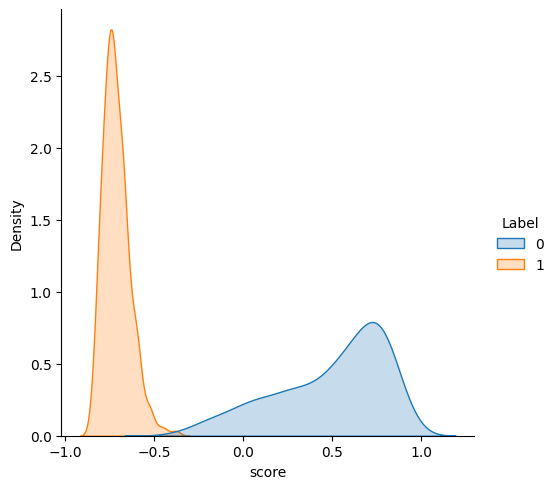

In [44]:
import seaborn as sns

fig = sns.displot(val_res_new, x="score", hue="Label", kind="kde", fill=True)

In [ ]:
triplet_criterion = TripletLoss(margin=1.0)

triplesiamese_model.eval()
validation_scores_positive = []
validation_scores_negative = []
validation_labels = []
validation_fv = []

with torch.no_grad():
    for ((inputs1, inputs2, inputs3), labels) in validate_dataloader:
        inputs1, inputs2, inputs3 = inputs1.to(device), inputs2.to(device), inputs3.to(device)
        labels = labels.to(device)
        emb1, emb2, emb3 = triplesiamese_model((inputs1, inputs2, inputs3))

        triplet_loss = triplet_criterion(emb1, emb2, emb3)
        validation_fv.append(triplet_loss.item())

        similarity_score_positive = F.cosine_similarity(emb1, emb2, dim=1)
        validation_scores_positive.extend(similarity_score_positive.cpu().numpy())

        similarity_score_negative = F.cosine_similarity(emb1, emb3, dim=1)
        validation_scores_negative.extend(similarity_score_negative.cpu().numpy())
        
        validation_labels.extend(labels.cpu().numpy().tolist())

validation_fv = torch.tensor(validation_fv).to(device)

val_res_df = pd.DataFrame({'cosine_similarity_positive': validation_scores_positive,
                           'cosine_similarity_negative': validation_scores_negative, 'label': validation_labels})

val_res_df

,cosine_similarity_positive,cosine_similarity_negative,label
0,0.671526,-0.543991,1.0
1,0.652764,-0.493386,1.0
2,0.729434,-0.483047,1.0
3,0.752885,-0.478569,1.0
4,0.734927,-0.520328,1.0
...,...,...,...
850,0.675061,-0.763782,1.0
851,0.683562,-0.761700,1.0
852,0.668793,-0.718355,1.0
853,0.668922,-0.733341,1.0


In [ ]:
val_res_df['predicted'] = (val_res_df['cosine_similarity_positive'] >= threshold).astype(int)

accuracy = accuracy_score(val_res_df['label'], val_res_df['predicted'])

fpr, tpr, _ = roc_curve(val_res_df['label'], val_res_df['cosine_similarity_positive'])

eer_threshold_idx = np.argmin(np.abs(tpr - (1 - fpr)))

eer = (fpr[eer_threshold_idx] + 1 - tpr[eer_threshold_idx]) / 2

conf_matrix = confusion_matrix(val_res_df['label'], val_res_df['predicted'])

print("Accuracy:", accuracy)
print("False Positive Rate (FPR):", fpr[eer_threshold_idx])
print("True Positive Rate (TPR):", tpr[eer_threshold_idx])
print("Equal Error Rate (EER):", eer)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9894736842105263
False Positive Rate (FPR): nan
True Positive Rate (TPR): 0.0
Equal Error Rate (EER): nan
Confusion Matrix:
[[  0   0]
 [  9 846]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [ ]:
val_res_df['predicted'] = (val_res_df['cosine_similarity_negative'] >= threshold).astype(int)

accuracy = accuracy_score(val_res_df['label'], val_res_df['predicted'])

fpr, tpr, _ = roc_curve(val_res_df['label'], val_res_df['cosine_similarity_negative'])

eer_threshold_idx = np.argmin(np.abs(tpr - (1 - fpr)))

eer = (fpr[eer_threshold_idx] + 1 - tpr[eer_threshold_idx]) / 2

conf_matrix = confusion_matrix(val_res_df['label'], val_res_df['predicted'])

print("Accuracy:", accuracy)
print("False Positive Rate (FPR):", fpr[eer_threshold_idx])
print("True Positive Rate (TPR):", tpr[eer_threshold_idx])
print("Equal Error Rate (EER):", eer)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.0
False Positive Rate (FPR): nan
True Positive Rate (TPR): 0.0
Equal Error Rate (EER): nan
Confusion Matrix:
[[  0   0]
 [855   0]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


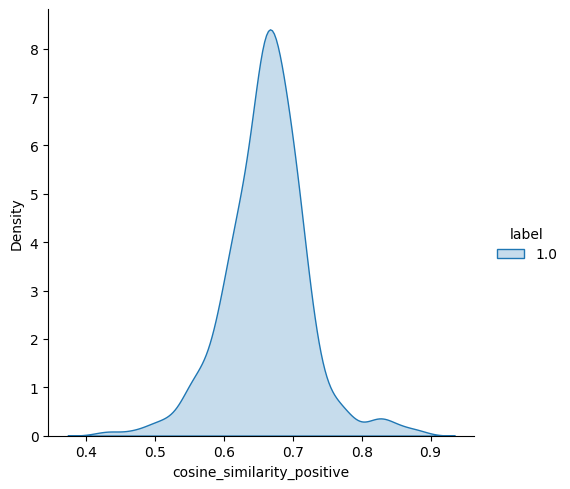

In [ ]:
import seaborn as sns

fig = sns.displot(val_res_df, x="cosine_similarity_positive", hue="label", kind="kde", fill=True)

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


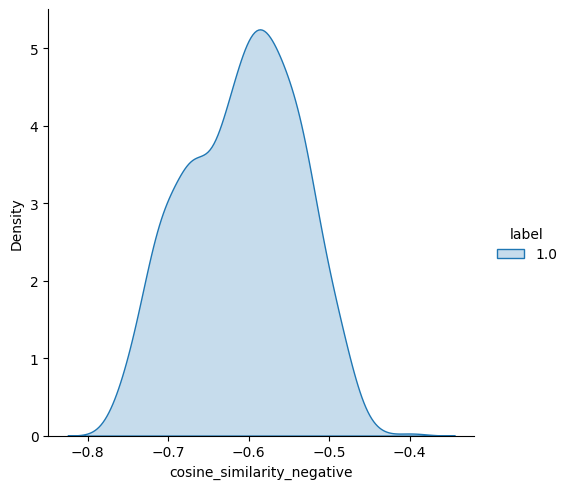

In [ ]:
import seaborn as sns

fig = sns.displot(val_res_df, x="cosine_similarity_negative", hue="label", kind="kde", fill=True)

In [ ]:
triplet_criterion = TripletLoss(margin=1.0)

triplesiamese_model.eval()
test_scores_positive = []
test_scores_negative = []
test_labels = []
test_fv = []

with torch.no_grad():
    for ((inputs1, inputs2, inputs3), labels) in test_dataloader:
        inputs1, inputs2, inputs3 = inputs1.to(device), inputs2.to(device), inputs3.to(device)
        labels = labels.to(device)
        emb1, emb2, emb3 = triplesiamese_model((inputs1, inputs2, inputs3))

        triplet_loss = triplet_criterion(emb1, emb2, emb3)
        test_fv.append(triplet_loss.item())

        similarity_score_positive = F.cosine_similarity(emb1, emb2, dim=1)
        test_scores_positive.extend(similarity_score_positive.cpu().numpy())

        similarity_score_negative = F.cosine_similarity(emb1, emb3, dim=1)
        test_scores_negative.extend(similarity_score_negative.cpu().numpy())
        
        test_labels.extend(labels.cpu().numpy().tolist())

test_fv = torch.tensor(test_fv).to(device)

test_res_df = pd.DataFrame({'cosine_similarity_positive': validation_scores_positive,
                           'cosine_similarity_negative': validation_scores_negative, 'label': validation_labels})

test_res_df

,cosine_similarity_positive,cosine_similarity_negative,label
0,0.671526,-0.543991,1.0
1,0.652764,-0.493386,1.0
2,0.729434,-0.483047,1.0
3,0.752885,-0.478569,1.0
4,0.734927,-0.520328,1.0
...,...,...,...
850,0.675061,-0.763782,1.0
851,0.683562,-0.761700,1.0
852,0.668793,-0.718355,1.0
853,0.668922,-0.733341,1.0


In [ ]:
test_res_df['predicted'] = (test_res_df['cosine_similarity_positive'] >= threshold).astype(int)

accuracy = accuracy_score(test_res_df['label'], test_res_df['predicted'])

fpr, tpr, _ = roc_curve(test_res_df['label'], test_res_df['cosine_similarity_positive'])

eer_threshold_idx = np.argmin(np.abs(tpr - (1 - fpr)))

eer = (fpr[eer_threshold_idx] + 1 - tpr[eer_threshold_idx]) / 2

conf_matrix = confusion_matrix(test_res_df['label'], test_res_df['predicted'])

print("Accuracy:", accuracy)
print("False Positive Rate (FPR):", fpr[eer_threshold_idx])
print("True Positive Rate (TPR):", tpr[eer_threshold_idx])
print("Equal Error Rate (EER):", eer)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9894736842105263
False Positive Rate (FPR): nan
True Positive Rate (TPR): 0.0
Equal Error Rate (EER): nan
Confusion Matrix:
[[  0   0]
 [  9 846]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [ ]:
test_res_df['predicted'] = (test_res_df['cosine_similarity_negative'] >= threshold).astype(int)

accuracy = accuracy_score(test_res_df['label'], test_res_df['predicted'])

fpr, tpr, _ = roc_curve(test_res_df['label'], test_res_df['cosine_similarity_negative'])

eer_threshold_idx = np.argmin(np.abs(tpr - (1 - fpr)))

eer = (fpr[eer_threshold_idx] + 1 - tpr[eer_threshold_idx]) / 2

conf_matrix = confusion_matrix(test_res_df['label'], test_res_df['predicted'])

print("Accuracy:", accuracy)
print("False Positive Rate (FPR):", fpr[eer_threshold_idx])
print("True Positive Rate (TPR):", tpr[eer_threshold_idx])
print("Equal Error Rate (EER):", eer)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.0
False Positive Rate (FPR): nan
True Positive Rate (TPR): 0.0
Equal Error Rate (EER): nan
Confusion Matrix:
[[  0   0]
 [855   0]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
